# Import Modules & Necessary Functions

In [ ]:
# install modules
!pip install ta
!pip install pystan==2.19.1.1
!pip install prophet

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29413 sha256=c857253f384561785d2b9a67acfc5473bc1e72da3b20984c7f8da35a1f194b00
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.2/16.2 MB 57.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.19.1.1-cp310-cp310-linux_x86_64.whl size=61975537 sha256=2f47d03e60229e19b7ac8e1db5fd56d67163269c89850042e575581d7dcec745
  Stored in directory: /root/.cache/pip/wheels/3d/1c/94/4516243362eedbedad15ac4389691ee3bf2d45bec2639c9d8b
Successfully built pystan


In [3]:
## import necessary modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from tqdm import tqdm

import os
import time
import datetime as dt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import zipfile
import ta

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
from sklearn import metrics
# for regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_percentage_error
from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

In [4]:
## ASCEND 측 제공 함수

def convert_tick_to_ohlcv(data):
    """
    Converts given Binance tick data into 1-hour interval OHLCV (Open, High, Low, Close, Volume) data.
    :param data: DataFrame with Tick data
    :return: DataFrame with the Open, High, Low, Close, Volume values
    """

    data['time'] = pd.to_datetime(data['time'], unit='ms')
    ohlcv = data.resample('1H', on='time').agg({
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum'})

    ohlcv.columns = ['Open', 'High', 'Low', 'Close', 'Volume']

    return ohlcv

def calculate_volatility(data, window=20):
    """
    Calculate the rolling volatility using the standard deviation of returns.
    :param data: DataFrame with OHLCV data
    :param window: The number of periods to use for calculating the standard deviation
    :return: DataFrame with the volatility values
    """

    # Calculate daily returns
    data['returns'] = data['Close'].pct_change()

    # Calculate the rolling standard deviation of returns
    data['volatility'] = data['returns'].rolling(window=window).std()

    return data

In [12]:
## 모든 전처리: User-Defined Functions

def count_hours_between_dates(start_date, end_date):
    # 시작 날짜와 종료 날짜를 datetime 객체로 변환
    start_datetime = datetime.strptime(start_date, "%Y-%m-%d %H:%M:%S")
    end_datetime = datetime.strptime(end_date, "%Y-%m-%d %H:%M:%S")

    # 1시간 간격으로 증가하는 timedelta 생성
    hour_interval = timedelta(hours=1)

    # 시작 날짜부터 종료 날짜까지 1시간 간격의 datetime 객체 생성
    current_datetime = start_datetime
    count = 0

    while current_datetime <= end_datetime:
        count += 1
        current_datetime += hour_interval

    return count

def closemake(df, startdate, enddate): # 끝에서 test 기간 차이 2배 기준으로 9000개 데이터의 코사인 유사도를 조사한 다음 가장 유사한 데이터 가장 마지막 위치 뽑아내기

  # convert to ohlcv
  df = calculate_volatility(df)
  df['volatility'].fillna(method='ffill', inplace=True)
  df['volatility'].fillna(method='bfill', inplace=True)

  diff = count_hours_between_dates(startdate, enddate)

  recent_pattern = df['volatility'].tail(diff*2).values
  max_similarity = -1
  most_similar_past_pattern = None
  most_similar_past_pattern_end_index = None
  for i in range(int(len(df)*0.95) - diff*2):
    past_pattern = df['volatility'].iloc[i:i+(diff*2)].values
    similarity = cosine_similarity([recent_pattern], [past_pattern])[0][0]

    # 최대 유사성 업데이트
    if similarity > max_similarity:
        max_similarity = similarity
        most_similar_past_pattern = past_pattern
        most_similar_past_pattern_end_index = i + diff*2-1

  print(f'최대 유사성: {max_similarity}')
  print(f'가장 유사한 과거 시점의 패턴: {most_similar_past_pattern}')
  print(f'가장 유사한 과거 시점의 패턴의 마지막 값 위치: {most_similar_past_pattern_end_index}')
  selected_data = df['Close'].iloc[most_similar_past_pattern_end_index+1:most_similar_past_pattern_end_index+diff+1]
  a=df['Close'].iloc[-1]
  c=df['Close'].iloc[-2]
  b=df['Close'].iloc[most_similar_past_pattern_end_index+1]
  selected_data=a-b+(a-c)+selected_data
  start_date = pd.Timestamp(startdate)
  pred = pd.DataFrame({'Close': selected_data.values}, index=pd.date_range(start=start_date, periods=len(selected_data), freq='H'))

  return pred

def feature_engineering1(df):
    df_fe = df.copy()

    # returns, volatility 계산
    df_fe = calculate_volatility(df_fe)

    # 시간대 index 설정
    df_fe['index'] = df_fe.index

    # returns, volatiltiy 결측치 보간
    df_fe['returns'] = df_fe['returns'].fillna(method='bfill')
    df_fe['volatility'] = df_fe['volatility'].fillna(method='bfill')

    # 시간대 정보 생성
    df_fe['Year'] = df_fe['index'].dt.year
    df_fe['Month'] = df_fe['index'].dt.month
    df_fe['Day'] = df_fe['index'].dt.day
    df_fe['Hour'] = df_fe['index'].dt.hour
    df_fe['Week'] = df_fe['index'].dt.isocalendar().week
    df_fe['Week'] = df_fe['Week'].astype(int)
    df_fe['WeekDay'] = df_fe['index'].dt.weekday
    df_fe['Quarter'] = df_fe['index'].dt.quarter

    # 불필요 변수 삭제
    df_fe.drop(['index', 'Year'], axis=1, inplace=True)

    return df_fe

def remove_vol_outliers(df): # 종속변수 이상치 변환 함수

  result = sm.tsa.seasonal_decompose(df['volatility'], model='additive')
  result.resid.fillna(method='ffill', inplace=True)
  result.resid.fillna(method='bfill', inplace=True)
  result.trend.fillna(method='ffill', inplace=True)
  result.trend.fillna(method='bfill', inplace=True)

  x = result.resid.index
  y = result.resid.values

  Q1 = np.percentile(y, 25)
  Q3 = np.percentile(y, 75)
  IQR = Q3 - Q1
  IQR = IQR if IQR > 0 else -1*IQR
  lower = Q1 - 5*IQR
  higher = Q3 + 5*IQR

  df2 = pd.DataFrame({'Original': df['volatility'], 'Trend': result.trend, 'Seasonal': result.seasonal, 'residual': result.resid})
  dfv_1=df2[(df2['residual'] < lower) | (df2['residual'] > higher)]
  df4=pd.DataFrame({'volatility' : df['volatility']})

  outliers_fraction = float(.01)
  scaler = StandardScaler()
  np_scaled = scaler.fit_transform(df4['volatility'].values.reshape(-1, 1))
  cast_scaled_df = pd.DataFrame(np_scaled)
  model = IsolationForest(contamination=outliers_fraction)
  model.fit(cast_scaled_df)
  df4['anomaly'] = model.predict(cast_scaled_df)

  a = df4.loc[df4['anomaly'] == -1, ['volatility']]

  df.loc[a.index, 'volatility'] = None
  df.loc[dfv_1.index, 'volatility'] = None
  df['volatility']=df['volatility'].interpolate()

  return df

def feature_engineering2(df):
    df_fe = df.copy()

    # 시계열 분해
    result = sm.tsa.seasonal_decompose(df_fe['volatility'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    if 'count_trend' not in df_fe.columns:
        if 'count_seasonal' not in df_fe.columns:
            df_fe = pd.concat([df_fe, Y_trend, Y_seasonal], axis=1)

    # 일별, 주별 평균
    Y_count_Day = df_fe[['volatility']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = df_fe[['volatility']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_count_Day], axis=1)
    if 'count_Week' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_count_Week], axis=1)

    # 각각 다른 indicator 추가 함수
    sma20 = ta.trend.sma_indicator(df_fe['Close'], window=20)
    sma20.fillna(method='ffill', inplace=True)
    sma20.fillna(method='bfill', inplace=True)
    sma20.columns = ['sma20']
    ema20 = ta.trend.ema_indicator(df_fe['Close'], window=20)
    ema20.fillna(method='ffill', inplace=True)
    ema20.fillna(method='bfill', inplace=True)
    ema20.columns = ['ema20']
    rsi = ta.momentum.rsi(df_fe['Close'], window=20)
    rsi.fillna(method='ffill', inplace=True)
    rsi.fillna(method='bfill', inplace=True)
    rsi.columns = ['rsi']
    macd = ta.trend.macd(df_fe['Close'], window_slow=20, window_fast=12)
    macd.fillna(method='ffill', inplace=True)
    macd.fillna(method='bfill', inplace=True)
    macd.columns = ['macd']
    indicator_bb = ta.volatility.BollingerBands(close=df_fe["Close"], window=20, window_dev=2)
    bb_bbm = indicator_bb.bollinger_mavg()
    bb_bbm.fillna(method='ffill', inplace=True)
    bb_bbm.fillna(method='bfill', inplace=True)
    bb_bbm.columns = ['bb_bbm']
    bb_bbh = indicator_bb.bollinger_hband()
    bb_bbh.fillna(method='ffill', inplace=True)
    bb_bbh.fillna(method='bfill', inplace=True)
    bb_bbh.columns = ['bb_bbh']
    bb_bbl = indicator_bb.bollinger_lband()
    bb_bbl.fillna(method='ffill', inplace=True)
    bb_bbl.fillna(method='bfill', inplace=True)
    bb_bbl.columns = ['bb_bbl']
    df_fe = pd.concat([df_fe, sma20, ema20, rsi, macd, bb_bbm, bb_bbh, bb_bbl], axis=1)

    # 차분
    Y_diff = df_fe[['Close']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in df_fe.columns:
        df_fe = pd.concat([df_fe, Y_diff], axis=1)

    # 지연값(lag)
    df_fe['count_lag1'] = df_fe['Close'].shift(1)
    df_fe['count_lag2'] = df_fe['Close'].shift(2)
    df_fe['count_lag1'].fillna(method='bfill', inplace=True)
    df_fe['count_lag2'].fillna(method='bfill', inplace=True)

    return df_fe

In [6]:
## time series 데이터: train_test split
def datasplit_ts(df, Y_colname, X_colname, criteria):
    df_train = df.loc[df.index < criteria,:]
    df_test = df.loc[df.index >= criteria,:]
    Y_train = df_train[Y_colname]
    X_train = df_train[X_colname]
    Y_test = df_test[Y_colname]
    X_test = df_test[X_colname]
    print('Train_size:', df_train.shape, 'Test_size:', df_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)

    return X_train, X_test, Y_train, Y_test

##  모든 독립변수들의 VIF 수치 확인 및 오름차순 정렬 후 상위 num_variables개 독립변수만 추출
def feature_engineering_XbyVIF(X_train, num_variables):
    vif = pd.DataFrame()
    vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i)
                         for i in range(X_train.shape[1])]
    vif['Feature'] = X_train.columns
    X_colname_vif = vif.sort_values(by='VIF_Factor', ascending=True)['Feature'][:num_variables].values

    return X_colname_vif

## 검증 함수화
def evaluation_reg(Y_real, Y_pred):
    MAPE = mean_absolute_percentage_error(Y_real, Y_pred)
    Score = pd.DataFrame([MAPE], index=['MAPE'], columns=['Score']).T

    return Score

## Train & Test 모두의 검증 함수화
def evaluation_reg_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te):
    Score_tr = evaluation_reg(Y_real_tr, Y_pred_tr)
    Score_te = evaluation_reg(Y_real_te, Y_pred_te)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']

    return Score_trte

    # Setting
    Resid = Residual.copy()
    if Resid.shape[0] >= 100:
        lag_max = 50
    else:
        lag_max = int(Resid.shape[0]/2)-1

## 실제 종속변수와 예측치 시각화
def plot_prediction(Y_true_pred):
    plt.figure(figsize=(16, 8))
    plt.plot(Y_true_pred, linewidth=5, label=Y_true_pred.columns)
    plt.xticks(fontsize=25, rotation=0)
    plt.yticks(fontsize=25)
    plt.xlabel('Index', fontname='serif', fontsize=28)
    plt.legend(fontsize=20)
    plt.grid()
    plt.show()

#실제 데이터 입력

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


`**날짜 입력!!!**`

실제 예측을 희망하는 시작 시점을 start_date 부분에, 종료 시점을 end_date 부분에 넣어주어야 합니다.

Ex) 실제 예측해야하는 시작 시점이 2월 5일, 종료 시점이 2월 11일, test data의 기간이 2024.01.01~2024.02.04일 경우

- start_date: '2024-02-05 00:00:00'
- end_date: '2024-02-11 00:00:00'
- test_start_date: '2024-01-01 00:00:00'

이렇게 설정하시면 됩니다!

In [ ]:
start_date =
end_date =
test_start_date =

여기서부터 그냥 실행하시면 됩니다!

In [20]:
# 2023.01.01~2024.02.04 데이터 로딩

df = pd.read_csv('원본 데이터 링크')

# ohlcv 형태로 변환
df = convert_tick_to_ohlcv(df)

# 'timestamp' 열을 datetime 형식으로 변환
df['time'] = pd.to_datetime(df['time'])

# 'timestamp' 열을 index로 설정
df.set_index('time', inplace=True)


# 결측치 보간
df['Volume'].replace(0, np.NaN, inplace=True)
df['Open'] = df['Open'].interpolate()
df['High'] = df['High'].interpolate()
df['Low'] = df['Low'].interpolate()
df['Close'] = df['Close'].interpolate()
df['Volume'] = df['Volume'].interpolate()

# 코사인 유사도 계산
pred = closemake(df,start_date,end_date)

# 데이터 전처리
df_all = pd.concat([df,pred])
df_all = feature_engineering1(df_all)
df_all = remove_vol_outliers(df_all)
df_all = feature_engineering2(df_all)

# 제공된 데이터/실제로 예측해야하는 데이터 분리
df_all = df_all.drop(['Open', 'High', 'Low', 'Volume','returns'], axis=1)
df_fe = df_all.loc[df_all.index < start_date]
df_pred = df_all.loc[df_all.index >= start_date]

# Train/Test 분리
Y_colname = ['volatility']
X_colname = [x for x in df_fe.columns if x not in Y_colname]
X_train, X_test, Y_train, Y_test = datasplit_ts(df_fe, Y_colname, X_colname, test_start_date)

# 모든 독립변수들의 VIF 수치 확인 및 오름차순 정렬
vif = pd.DataFrame()
vif['VIF_Factor'] = [variance_inflation_factor(X_train.values, i)
                     for i in range(X_train.shape[1])]
vif['Feature'] = X_train.columns
vif.sort_values(by='VIF_Factor', ascending=True)

# VIF로 독립변수 추출 갯수 증가에 따른 성능변화 확인
eval_tr = pd.DataFrame()
eval_te = pd.DataFrame()
for i in tqdm(range(1,len(X_train.columns)+1)):
    X_colname_vif = feature_engineering_XbyVIF(X_train, i)
    X_train_RSM, X_test_RSM = X_train[X_colname_vif].copy(), X_test[X_colname_vif].copy()

    # Applying Base Model
    model_lr_RSM = sm.OLS(Y_train, X_train_RSM).fit()
    Y_trpred_RSM = model_lr_RSM.predict(X_train_RSM).values
    Y_tepred_RSM = model_lr_RSM.predict(X_test_RSM).values

    # Evaluation
    Score_RSM = evaluation_reg_trte(Y_train, Y_trpred_RSM, Y_test, Y_tepred_RSM)
    eval_tr = pd.concat([eval_tr, Score_RSM.loc[['Train']]], axis=0)
    eval_te = pd.concat([eval_te, Score_RSM.loc[['Test']]], axis=0)
eval_tr.index = range(1,len(X_train.columns)+1)
eval_te.index = range(1,len(X_train.columns)+1)

plt.figure(figsize=(12,5))
plt.plot(eval_tr/eval_tr.max())
plt.legend(eval_tr.columns)
plt.title('Evaluation of Train Set')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(eval_te/eval_te.max())
plt.legend(eval_te.columns)
plt.title('Evaluation of Test Set')
plt.show()

Number_of_selected_X=9 # 변수 확인 후 설정

# 다중공산성 높은 변수 제거
print('Number_of_Total_X: ', len(X_train.columns))
X_colname_vif = feature_engineering_XbyVIF(X_train, Number_of_selected_X)
print('Number_of_Selected_X: ', len(X_colname_vif))
X_train_RSM, X_test_RSM = X_train[X_colname_vif].copy(), X_test[X_colname_vif].copy()

# 선택된 변수
print('Selected X:', X_colname_vif)
selected_x = X_colname_vif

FileNotFoundError: [Errno 2] No such file or directory: '원본 데이터 링크'

최적 하이퍼 파라미터:  {'max_depth': 9, 'min_samples_leaf': 5, 'min_samples_split': 2, 'n_estimators': 100}


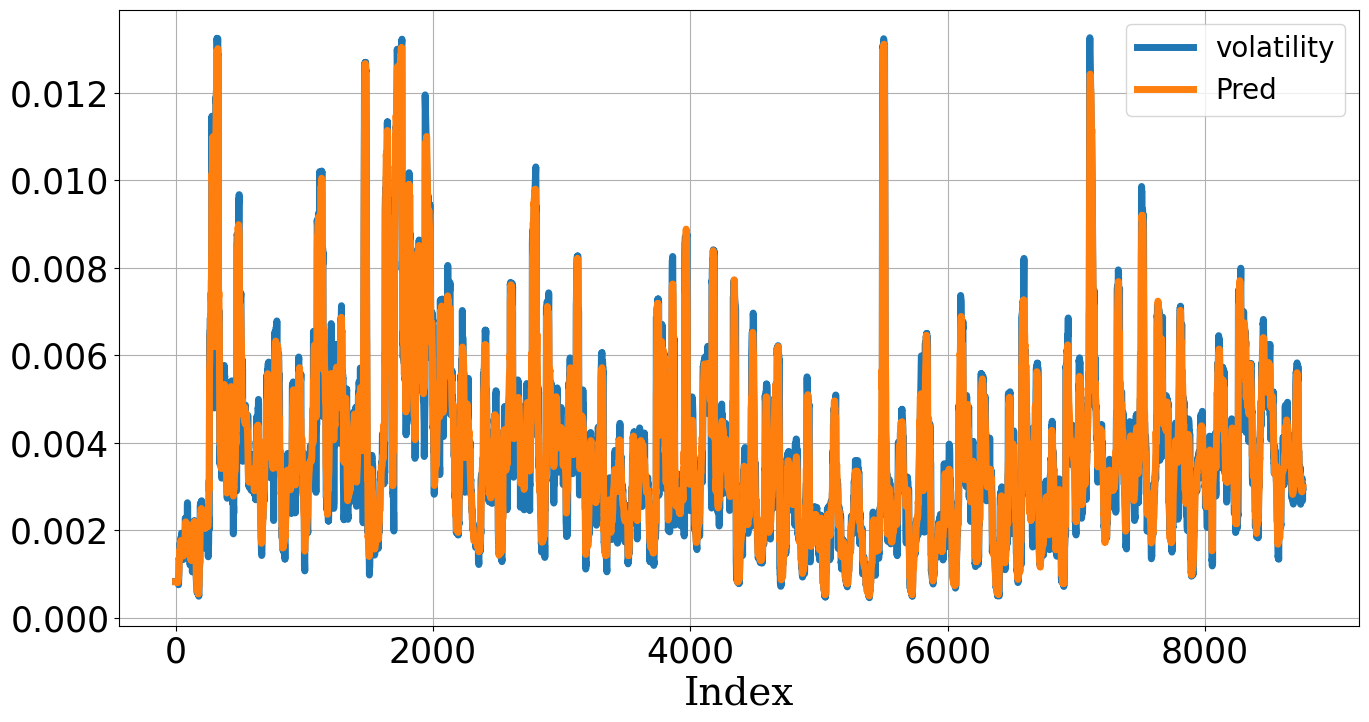

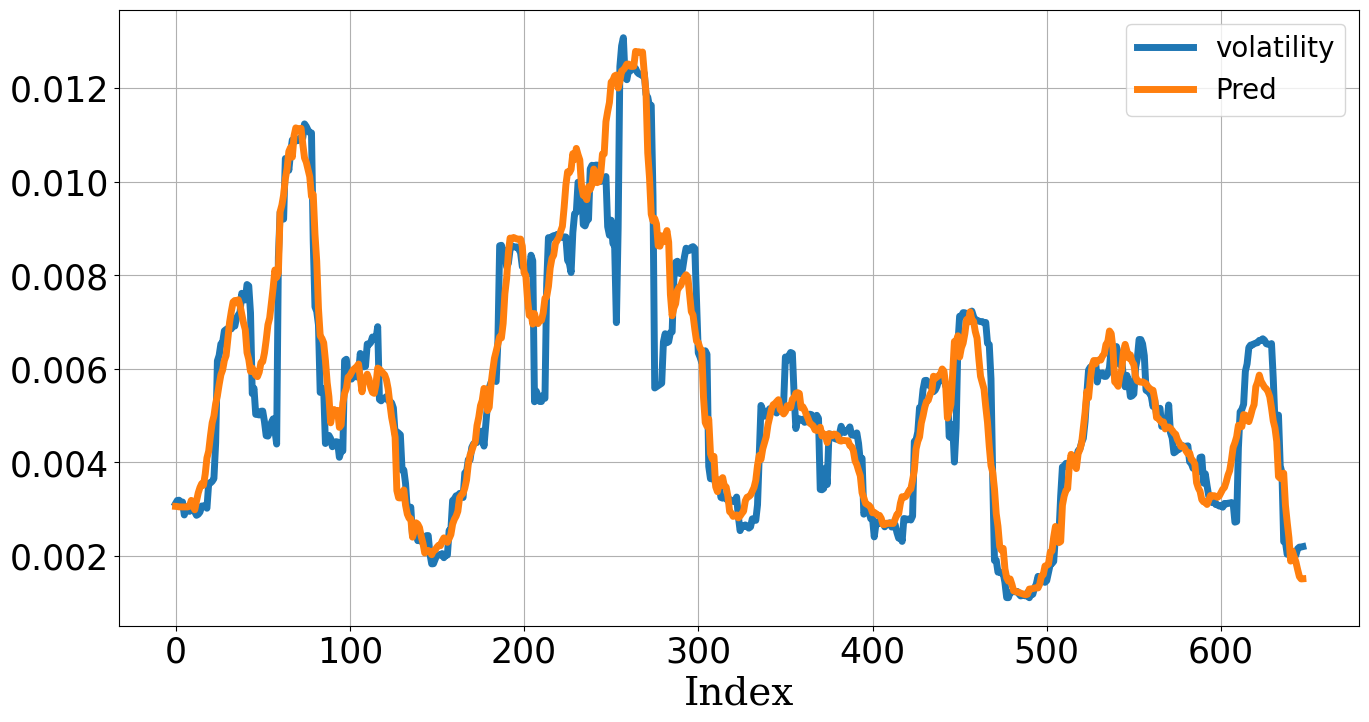

,MAPE
Train,0.092373
Test,0.121060


In [15]:
## RandomForest Regressor
model_rf = RandomForestRegressor(random_state=42)
params = {'n_estimators': [100],
          'max_depth': [5, 7, 9], # 7
          'min_samples_leaf': [5, 7, 9, 11, 14], # 14
          'min_samples_split': [1, 2, 3]} # 3
model_rf_cv = GridSearchCV(estimator=model_rf, param_grid=params, cv=10, n_jobs=-1)
model_rf_cv.fit(X_train_RSM, Y_train)
print("최적 하이퍼 파라미터: ", model_rf_cv.best_params_)

Y_trpred = pd.DataFrame(model_rf_cv.predict(X_train_RSM),
                        index=Y_train.index, columns=['Pred'])
Y_tepred = pd.DataFrame(model_rf_cv.predict(X_test_RSM),
                        index=Y_test.index, columns=['Pred'])
plot_prediction(pd.concat([Y_train, Y_trpred], axis=1).reset_index().iloc[:,1:])
plot_prediction(pd.concat([Y_test, Y_tepred], axis=1).reset_index().iloc[:,1:])

# 분석 검증
Score = evaluation_reg_trte(Y_train, Y_trpred, Y_test, Y_tepred)
display(Score)

# 실제 예측

In [16]:
# 예측용 데이터 분리
Y_colname_final = ['volatility']
X_colname_final = [x for x in df_pred.columns if x in selected_x]

new_df = df_pred[X_colname_final]

In [17]:
new_df = new_df[X_train_RSM.columns]
new_df.index.name = 'time'

In [18]:
# 최종 예측 결과
Y_finalpred = pd.DataFrame(model_rf_cv.predict(new_df), index=new_df.index, columns=['Pred_Volatility'])

# Y_finalpred.to_csv("submission.csv")